# Loading Road Network Data From OpenStreetMaps

In [2]:
import osmnx as ox
import networkx as nx

import os 

def load_or_download_graph(address, filepath):
    """
    Load a graph from a file if it exists, otherwise download it from OpenStreetMap.

    Parameters:
    - address (str): The address or place name to retrieve the graph for.
    - filepath (str): The filepath to save or load the graph from.

    Returns:
    - networkx.Graph: The loaded or downloaded graph.
    """
    # Check if the file exists
    if os.path.exists(filepath):
        # If the file exists, load the graph from the file
        G = ox.load_graphml(filepath)
        print("Graph loaded from file.")
    else:
        # If the file doesn't exist, download the graph from OpenStreetMap
        G = ox.graph_from_place(address, network_type="drive")
        # Save the graph to the specified filepath
        ox.save_graphml(G, filepath=filepath)
        print("Graph downloaded from OpenStreetMap and saved to file.")
    return G

In [3]:
import osmnx as ox


address = "Kathmandu valley"
filepath = "kathmandu_lalitpur_bhaktapur.graphml"
G = load_or_download_graph(address, filepath)


Graph loaded from file.


# 2. Routing

In [4]:
# Define the latitude and longitude coordinates for the origin and destination
orig_coords = (27.70172718, 85.33310237)  # Example coordinates for the origin
dest_coords = (27.70113311, 85.28545914)    # Example coordinates for the destination

# Find the nearest network nodes to the specified coordinates
orig_node = ox.distance.nearest_nodes(G, orig_coords[1], orig_coords[0])
dest_node = ox.distance.nearest_nodes(G, dest_coords[1], dest_coords[0])

## 2.1 Shortest Route

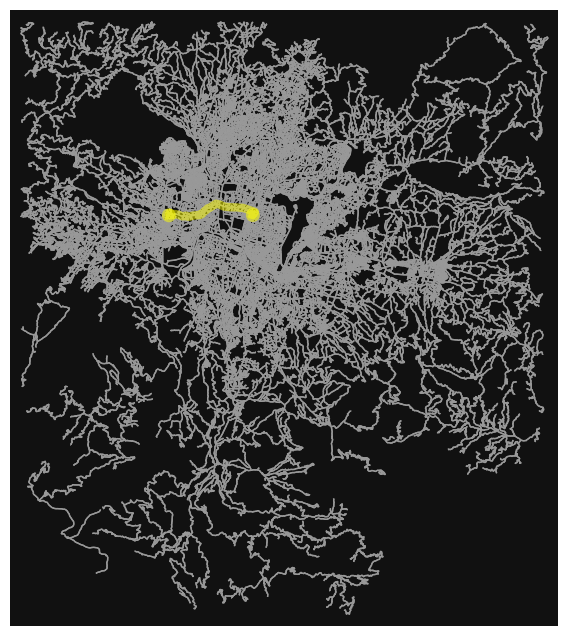

In [5]:
# Find the shortest path (by distance) between the specified nodes
route = ox.shortest_path(G, orig_node, dest_node, weight="length")

# Plot the network with the shortest path highlighted
fig, ax = ox.plot_graph_route(
    G, route, route_color="yellow", route_linewidth=6, node_size=0
)


## 2.2 Multiple Routes

In [6]:
# Find the nearest network nodes to the specified coordinates
orig_node = ox.distance.nearest_nodes(G, orig_coords[1], orig_coords[0])
dest_node = ox.distance.nearest_nodes(G, dest_coords[1], dest_coords[0])

# Find the k-shortest paths (by distance) between the specified nodes
routes = ox.k_shortest_paths(G, orig_node, dest_node, k=10, weight="length")

routes = list(routes)

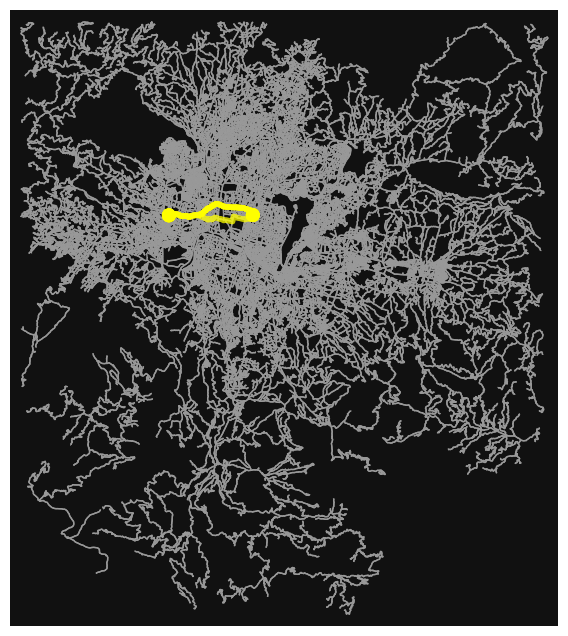

In [7]:
# Plot the network with the k-shortest paths highlighted
fig, ax = ox.plot_graph_routes(
    G, routes, route_colors="yellow", route_linewidth=4, node_size=0
)

### 2.2.1 Web Map

In [66]:
import folium

# Create a Folium map centered around the average of the coordinates
map_center = [(orig_coords[0] + dest_coords[0]) / 2, (orig_coords[1] + dest_coords[1]) / 2]
m = folium.Map(location=map_center, zoom_start=12)

# Plot the start point in a green marker
folium.Marker(location=(orig_coords[0], orig_coords[1]), icon=folium.Icon(color='green')).add_to(m)

# Plot the end point in a red marker
folium.Marker(location=(dest_coords[0], dest_coords[1]), icon=folium.Icon(color='red')).add_to(m)

# Plot the network with the k-shortest paths highlighted
for route in routes:
    # Convert the route nodes to coordinates
    route_coords = [(G.nodes[node]["y"], G.nodes[node]["x"]) for node in route]

    # Create a line for the route
    folium.PolyLine(locations=route_coords, color='orange', weight=4).add_to(m)

# Display the map in the notebook
m


# 3. Travel Time

## 3.1. Travel Time Information

In [8]:
# impute speed on all edges missing data
G = ox.add_edge_speeds(G)

# calculate travel time (seconds) for all edges
G = ox.add_edge_travel_times(G)

In [9]:
# see mean speed/time values by road type
edges = ox.graph_to_gdfs(G, nodes=False)
edges["highway"] = edges["highway"].astype(str)
edges.groupby("highway")[["length", "speed_kph", "travel_time"]].mean().round(1)

,length,speed_kph,travel_time
highway,,,
"['primary', 'secondary']",792.8,43.0,66.4
"['residential', 'living_street']",174.6,25.1,25.0
"['road', 'residential']",574.6,34.8,59.4
"['road', 'unclassified']",1439.2,34.8,148.9
"['secondary', 'primary']",792.8,41.3,69.1
"['secondary', 'residential']",202.2,41.3,17.6
"['tertiary', 'residential']",480.1,31.7,54.4
"['tertiary', 'secondary']",90.9,31.8,10.3
"['unclassified', 'living_street']",216.3,28.9,29.0


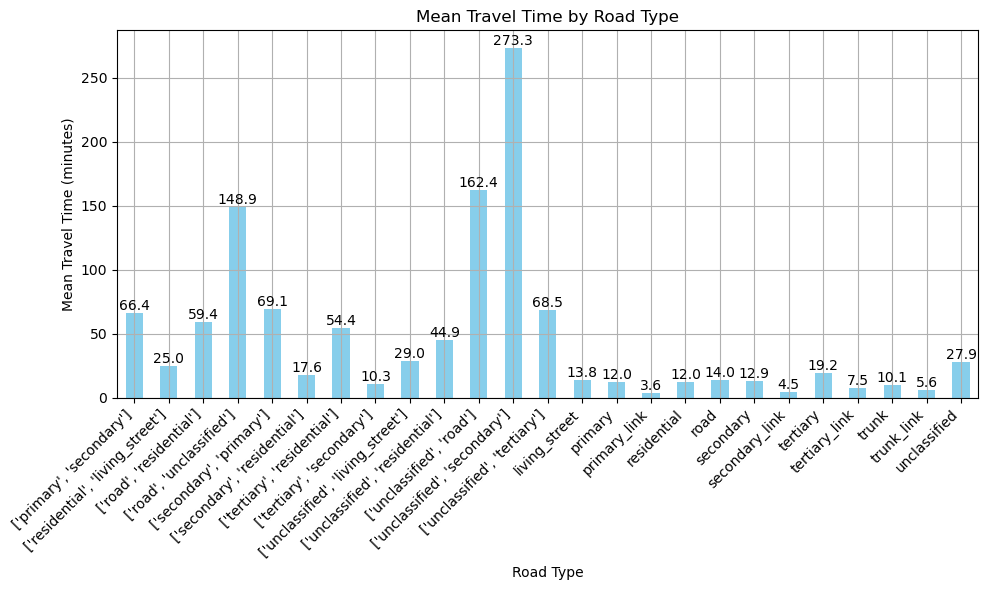

In [10]:
import matplotlib.pyplot as plt

# Group the edges by highway type and calculate mean values
mean_values = edges.groupby("highway")[["length", "speed_kph", "travel_time"]].mean().round(1)

# Plotting
plt.figure(figsize=(10, 6))

# Plot mean travel time by road type with grid
mean_values["travel_time"].plot(kind="bar", color="skyblue", grid=True)

# Add labels and title
plt.xlabel("Road Type")
plt.ylabel("Mean Travel Time (minutes)")
plt.title("Mean Travel Time by Road Type")
plt.xticks(rotation=45, ha='right')

# Add values on top of each bar
for index, value in enumerate(mean_values["travel_time"]):
    plt.text(index, value, str(value), ha='center', va='bottom')

# Show plot
plt.tight_layout()
plt.show()


In [12]:
# Define color_travel_time function
def color_travel_time(travel_time):
    if travel_time < 10:
        return 'green'
    elif 10 <= travel_time <= 20:
        return 'yellow'
    else:
        return 'red'


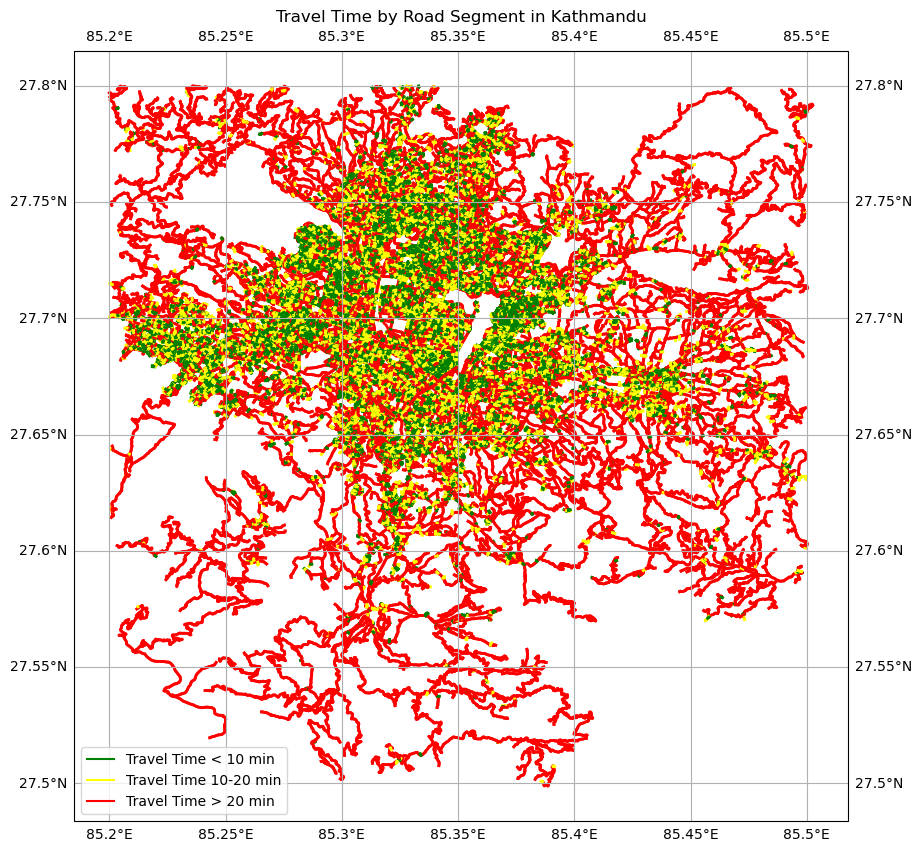

In [14]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# Create a Matplotlib figure and axes
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot each edge on the map with color representing travel time
for index, row in edges.iterrows():
    color = color_travel_time(row['travel_time'])
    ax.plot(*row['geometry'].xy, color=color, linewidth=2)

# Add title and grid
ax.set_title('Travel Time by Road Segment in Kathmandu')
ax.gridlines(draw_labels=True)

# Add legend
ax.plot([], [], color='green', label='Travel Time < 10 min')
ax.plot([], [], color='yellow', label='Travel Time 10-20 min')
ax.plot([], [], color='red', label='Travel Time > 20 min')
ax.legend()

plt.show()


## 3.2. Generate route by length and travel time

In [82]:
# calculate two routes by minimizing travel distance vs travel time
route1 = ox.shortest_path(G, orig_node, dest_node, weight="length")
route2 = ox.shortest_path(G, orig_node, dest_node, weight="travel_time")

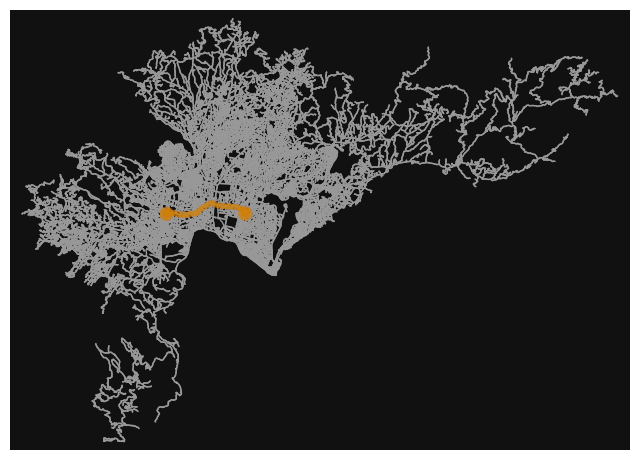

In [83]:
# plot the routes
fig, ax = ox.plot_graph_routes(
    G, routes=[route1, route2], route_colors=["r", "y"], route_linewidth=6, node_size=0
)

# Kathamandu Valley

In [88]:
import osmnx as ox

# Define the bounding box coordinates
north = 27.8
south = 27.5
east = 85.5
west = 85.2

# Create a bounding box using these coordinates
bbox = north, south, east, west

# Download the street network graph for the specified bounding box
G = ox.graph_from_bbox(north, south, east, west, network_type='drive', simplify=True)

# You can save the graph if needed
ox.save_graphml(G, filepath='kathmandu_lalitpur_bhaktapur.graphml')

# Use the graph as needed for further analysis or visualization


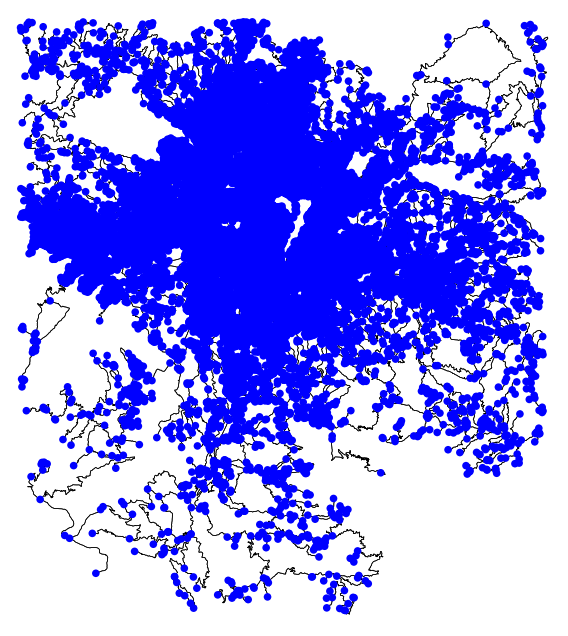

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [89]:
import osmnx as ox

# Load the graph from the saved GraphML file
G = ox.load_graphml(filepath='kathmandu_lalitpur_bhaktapur.graphml')

# Plot the loaded graph
ox.plot_graph(G, bgcolor='w', node_color='b', edge_color='k', node_size=30, edge_linewidth=0.5)
